# HDP-base spell-sound analyzer
# developed by Kow Kuroda (kow.kuroda@gmail.com)
# History
2024/08/19 Cython を使った cy_gen_ngrams を利用可能にした
2024/09/02 n-gram 生成の generic function を導入し，コードを簡略化
2024/09/06 term の階層クラスタリングを実装

In [117]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [118]:
## imports
import os, sys
import pprint as pp
import unicodedata

In [119]:
## 一つ上の階層のファイルを見るように設定
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [120]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [121]:
## Cython を使うかどうか
use_Cython = False
if use_Cython:
    %load_ext Cython

In [122]:
## term settings
term_classes        = [ 'spell', 'sound' ]
term_class          = term_classes[1]
ngram_is_inclusive  = True
inclusion_degree    = None

## doc settings
max_doc_size        = 11
min_doc_size        =  3
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

### boundary handling
mark_boundaries     = False
boundary_mark       = "#"

## term setting
term_is_skippy      = False
n_for_ngram         = 3
max_gap_ratio       = 0.8
max_gap_size        = round(max_doc_size * max_gap_ratio)
print(f"term_class: {term_class}")
print(f"term_is_skippy: {term_is_skippy}")
print(f"max_gap_size: {max_gap_size}")
print(f"n_for_ngram: {n_for_ngram}")

## symbols
gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if term_class == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")
## define term_type
if term_class == 'spell':
    if term_is_skippy:
        term_type = f"sp_skippy{n_for_ngram}gram"
    else:
        term_type = f"sp_{n_for_ngram}gram"
else:
    if term_is_skippy:
        term_type = f"sn_skippy{n_for_ngram}gram"
    else:
        term_type = f"sn_{n_for_ngram}gram"
## check
print(f"term_type: {term_type}")

max_doc_size: 11
min_doc_size: 3
term_class: sound
term_is_skippy: False
max_gap_size: 9
n_for_ngram: 3
accent_status: -unaccented
term_type: sn_3gram


In [123]:
## target language
## a key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German Nouns',
                        'de_non_N_only' : 'German Non-nouns',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nl', 'ro', 'sw',
                        'ir' # This lacks sound
                    ]
## check
target_lang_key  = target_lang_keys[4]
print(f"target_lang_key: {target_lang_key}")
print(f"target lang: {target_lang_dict[target_lang_key]} [{target_lang_key}]")

## target_attr [effective only for Irish]
target_class = ""

#target_class = None # This causes an unrediable error
if target_lang_key == "ir":
    target_classes = [ 'adjectives', 'nouns', 'verbs' ]
    target_class = f"-{target_classes[3]}"
print(f"target_class: {target_class}")

target_lang_key: en_A_only
target lang: English adj (WN) [en_A_only]
target_class: 


In [124]:
## LDA/HDP
apply_term_filtering = True
## The following parameters need to be relatively large to prevent "Row sum not equal 1" error
term_minfreq       = 2
## The following value is crucial to prevent "Row sum not equal 1" error
min_bot_size       = min_doc_size # 3
abuse_threshold    = 0.05 # larger value selects shorter units, smaller value selects longer units
# number of terms listed for a given topic
n_docs_to_show     = 15
n_terms_to_show    = 20
n_terms_to_save    = 120
# saving output
save_LDAvis          = False
save_topic_structure = False

In [125]:
## sampling
source_sampling          = True
source_sampling_rate     = 0.5
source_sampling_max_size = 5000
second_sampling          = False
second_sampling_rate     = 0.7

In [126]:
## set target files
import glob
data_dir1     = "data/open-dict-ipa/data1"
data_dir2     = "data/open-dict-ipa/data1a"
data_dir3     = "data/wn3"
data_dir4     = "data/irish"
target_files  = glob.glob(f"{data_dir1}/*")
target_files2 = glob.glob(f"{data_dir2}/*")
target_files.extend(target_files2)
target_files3 = glob.glob(f"{data_dir3}/*")
target_files.extend(target_files3)
target_files4 = glob.glob(f"{data_dir4}/*")
target_files.extend(target_files4)
#
target_files = sorted([ file for file in target_files if ".csv" in file ])
pp.pprint(target_files)

['data/irish/word-irish-adjectives-spell.csv',
 'data/irish/word-irish-noun-phrases-spell.csv',
 'data/irish/word-irish-nouns-spell.csv',
 'data/irish/word-irish-possessives-spell.csv',
 'data/irish/word-irish-prepositions-spell.csv',
 'data/irish/word-irish-verbs-spell.csv',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/is.csv.gz',
 'data/open-dict-ipa/data1/ja.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 '

In [127]:
## get source data from files
import pandas as pd
import gzip
#target_language_key = "en_US" # can be changed to get other languages
#if target_class != "" or target_class is not None:
if target_class != "":
    target_file = [ f for f in target_files if target_lang_key in f and target_class in f ][0]
else:
    target_file = [ f for f in target_files if target_lang_key in f ][0]
print(f"processing: {target_file}")
##
if target_lang_key == "ir":
    col_names = ['spell', 'POS']
else:
    col_names = ['spell', 'sound']

##
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

## normalize characters
raw_df['spell'] = raw_df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

## modify sound
try:
    sounds = raw_df['sound'].apply(lambda x: x.strip('/') )
    sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
    raw_df['sound'] = sounds
except (AttributeError, KeyError):
    pass
#
raw_df.sample(10)

processing: data/wn3/en_A_only.csv


,spell,sound
3739,operatic,ˌɑpɝˈætɪk
2160,fifteen,ˈfɪfˈtin
4629,seething,ˈsiðɪŋ
2548,highflying,ˈhaɪˌfɫaɪɪŋ
3134,legal,ˈɫiɡəɫ
3944,persuasive,pɝˈsweɪsɪv
1619,disarming,dɪˈsɑɹmɪŋ
2406,grateful,ˈɡɹeɪtfəɫ
4152,printable,ˈpɹɪntəbəɫ
4688,shameless,ˈʃeɪmɫəs


In [128]:
## source sampling
len(raw_df)
if source_sampling:
	print(f"source sampling applied")
	if len(raw_df) >= source_sampling_max_size:
		raw_df = raw_df.sample(source_sampling_max_size)
	else:
		raw_df = raw_df.sample(round(len(raw_df) * source_sampling_rate))
## remove accent marking
if suppress_accents:
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass
## add boudary marks
if mark_boundaries:
	raw_df['spell'] = raw_df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(raw_df)

source sampling applied
            spell        sound
1144    completed    kəmpɫitəd
3418    miserable     mɪzɝəbəɫ
2136       female       fimeɪɫ
2135       feline       fiɫaɪn
4652     separate      sɛpɝeɪt
...           ...          ...
3983      pinched       pɪntʃt
731       bootleg       butɫɛɡ
3533     narcotic     nɑɹkɑtɪk
5365  unbreakable  ənbɹeɪkəbəɫ
329      antitank     æntitæŋk

[5000 rows x 2 columns]


In [129]:
## generate 1-grams for spell and sound
## spell
raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: list(str(x)))
# add column of size
raw_df['sp_size'] = raw_df['sp_1gram'].apply(lambda x: len(x))
# add column of count of '-' inside
raw_df['hyphen'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("-"))
# add column of count of '.' inside
raw_df['period'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("."))
## sound
# takes the first entry, removes '/' around
try:
    raw_df['sn_1gram'] = raw_df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass
# add column of size
try:
    raw_df['sn_size'] = raw_df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass
## check
raw_df

,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
1144,completed,kəmpɫitəd,"[c, o, m, p, l, e, t, e, d]",9,0,0,"[k, ə, m, p, ɫ, i, t, ə, d]",9
3418,miserable,mɪzɝəbəɫ,"[m, i, s, e, r, a, b, l, e]",9,0,0,"[m, ɪ, z, ɝ, ə, b, ə, ɫ]",8
2136,female,fimeɪɫ,"[f, e, m, a, l, e]",6,0,0,"[f, i, m, e, ɪ, ɫ]",6
2135,feline,fiɫaɪn,"[f, e, l, i, n, e]",6,0,0,"[f, i, ɫ, a, ɪ, n]",6
4652,separate,sɛpɝeɪt,"[s, e, p, a, r, a, t, e]",8,0,0,"[s, ɛ, p, ɝ, e, ɪ, t]",7
...,...,...,...,...,...,...,...,...
3983,pinched,pɪntʃt,"[p, i, n, c, h, e, d]",7,0,0,"[p, ɪ, n, t, ʃ, t]",6
731,bootleg,butɫɛɡ,"[b, o, o, t, l, e, g]",7,0,0,"[b, u, t, ɫ, ɛ, ɡ]",6
3533,narcotic,nɑɹkɑtɪk,"[n, a, r, c, o, t, i, c]",8,0,0,"[n, ɑ, ɹ, k, ɑ, t, ɪ, k]",8
5365,unbreakable,ənbɹeɪkəbəɫ,"[u, n, b, r, e, a, k, a, b, l, e]",11,0,0,"[ə, n, b, ɹ, e, ɪ, k, ə, b, ə, ɫ]",11


In [130]:
## filtering raw_data by size
print(f"term_type: {term_type}")
if "sp_" in term_type:
    df_filtered = raw_df[ (raw_df['sp_size'] <= max_doc_size) & (raw_df['sp_size'] >= min_doc_size) & (raw_df['hyphen'] == 0) & (raw_df['period'] == 0) ]
else:
    df_filtered = raw_df[ (raw_df['sn_size'] <= max_doc_size) & (raw_df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_type: sn_3gram


,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
1144,completed,kəmpɫitəd,"[c, o, m, p, l, e, t, e, d]",9,0,0,"[k, ə, m, p, ɫ, i, t, ə, d]",9
3418,miserable,mɪzɝəbəɫ,"[m, i, s, e, r, a, b, l, e]",9,0,0,"[m, ɪ, z, ɝ, ə, b, ə, ɫ]",8
2136,female,fimeɪɫ,"[f, e, m, a, l, e]",6,0,0,"[f, i, m, e, ɪ, ɫ]",6
2135,feline,fiɫaɪn,"[f, e, l, i, n, e]",6,0,0,"[f, i, ɫ, a, ɪ, n]",6
4652,separate,sɛpɝeɪt,"[s, e, p, a, r, a, t, e]",8,0,0,"[s, ɛ, p, ɝ, e, ɪ, t]",7
...,...,...,...,...,...,...,...,...
3983,pinched,pɪntʃt,"[p, i, n, c, h, e, d]",7,0,0,"[p, ɪ, n, t, ʃ, t]",6
731,bootleg,butɫɛɡ,"[b, o, o, t, l, e, g]",7,0,0,"[b, u, t, ɫ, ɛ, ɡ]",6
3533,narcotic,nɑɹkɑtɪk,"[n, a, r, c, o, t, i, c]",8,0,0,"[n, ɑ, ɹ, k, ɑ, t, ɪ, k]",8
5365,unbreakable,ənbɹeɪkəbəɫ,"[u, n, b, r, e, a, k, a, b, l, e]",11,0,0,"[ə, n, b, ɹ, e, ɪ, k, ə, b, ə, ɫ]",11


In [131]:
## define df after second sampling if any
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

4566

In [132]:
## generic function for n-gram generation
def add_ngram_to_df(dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        target_var = f"{prefix}skippy{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check)] for x in unigrams ]
        else:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check)] for x in unigrams ]
    else:
        import gen_ngrams
        if skippy:
            ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) for x in unigrams ]
        else:
            ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]
    ## 包括的 n-gramの生成
    if inclusive:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            supplement_var = f"{prefix}skippy{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

# Spell

In [133]:
## spell 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
1144    [co, om, mp, pl, le, et, te, ed, c, o, m, p, l...
3418    [mi, is, se, er, ra, ab, bl, le, m, i, s, e, r...
2136               [fe, em, ma, al, le, f, e, m, a, l, e]
2135               [fe, el, li, in, ne, f, e, l, i, n, e]
4652    [se, ep, pa, ar, ra, at, te, s, e, p, a, r, a,...
                              ...                        
3983        [pi, in, nc, ch, he, ed, p, i, n, c, h, e, d]
731         [bo, oo, ot, tl, le, eg, b, o, o, t, l, e, g]
3533    [na, ar, rc, co, ot, ti, ic, n, a, r, c, o, t,...
5365    [un, nb, br, re, ea, ak, ka, ab, bl, le, u, n,...
329     [an, nt, ti, it, ta, an, nk, a, n, t, i, t, a,...
Name: sp_2gram, Length: 4566, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74565/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [134]:
## frequencies of 2grams
ngram_is_skippy = False
n_now = 2
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('ed', 1059),
 ('in', 790),
 ('al', 608),
 ('te', 583),
 ('le', 572),
 ('ti', 559),
 ('er', 520),
 ('re', 520),
 ('ic', 497),
 ('en', 462),
 ('ng', 436),
 ('nt', 430),
 ('at', 419),
 ('st', 419),
 ('ar', 396),
 ('on', 350),
 ('ra', 347),
 ('un', 343),
 ('an', 341),
 ('ri', 341),
 ('ve', 330),
 ('or', 314),
 ('de', 304),
 ('li', 303),
 ('bl', 293),
 ('us', 280),
 ('es', 275),
 ('ne', 274),
 ('ou', 274),
 ('is', 271)]

In [135]:
## spell 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_3gram
min_size: 1
supplement_var: sp_2gram
1144    [com, omp, mpl, ple, let, ete, ted, co, om, mp...
3418    [mis, ise, ser, era, rab, abl, ble, mi, is, se...
2136    [fem, ema, mal, ale, fe, em, ma, al, le, f, e,...
2135    [fel, eli, lin, ine, fe, el, li, in, ne, f, e,...
4652    [sep, epa, par, ara, rat, ate, se, ep, pa, ar,...
                              ...                        
3983    [pin, inc, nch, che, hed, pi, in, nc, ch, he, ...
731     [boo, oot, otl, tle, leg, bo, oo, ot, tl, le, ...
3533    [nar, arc, rco, cot, oti, tic, na, ar, rc, co,...
5365    [unb, nbr, bre, rea, eak, aka, kab, abl, ble, ...
329     [ant, nti, tit, ita, tan, ank, an, nt, ti, it,...
Name: sp_3gram, Length: 4566, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74565/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [136]:
## frequencies of 3grams
ngram_is_skippy = False
n_now = 3
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('ing', 370),
 ('ble', 237),
 ('ent', 216),
 ('ted', 209),
 ('abl', 183),
 ('ive', 176),
 ('ous', 176),
 ('tic', 172),
 ('ate', 164),
 ('ess', 129),
 ('red', 123),
 ('ter', 122),
 ('tiv', 119),
 ('ati', 118),
 ('con', 106),
 ('ial', 90),
 ('ant', 89),
 ('les', 89),
 ('tin', 89),
 ('ine', 87),
 ('cal', 87),
 ('ist', 86),
 ('sti', 84),
 ('ned', 84),
 ('nal', 84),
 ('ste', 82),
 ('ica', 78),
 ('ect', 77),
 ('res', 77),
 ('ere', 76)]

In [137]:
## spell 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_4gram
min_size: 1
supplement_var: sp_3gram
1144    [comp, ompl, mple, plet, lete, eted, com, omp,...
3418    [mise, iser, sera, erab, rabl, able, mis, ise,...
2136    [fema, emal, male, fem, ema, mal, ale, fe, em,...
2135    [feli, elin, line, fel, eli, lin, ine, fe, el,...
4652    [sepa, epar, para, arat, rate, sep, epa, par, ...
                              ...                        
3983    [pinc, inch, nche, ched, pin, inc, nch, che, h...
731     [boot, ootl, otle, tleg, boo, oot, otl, tle, l...
3533    [narc, arco, rcot, coti, otic, nar, arc, rco, ...
5365    [unbr, nbre, brea, reak, eaka, akab, kabl, abl...
329     [anti, ntit, tita, itan, tank, ant, nti, tit, ...
Name: sp_4gram, Length: 4566, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74565/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [138]:
## spell 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_5gram
min_size: 1
supplement_var: sp_4gram
1144    [compl, omple, mplet, plete, leted, comp, ompl...
3418    [miser, isera, serab, erabl, rable, mise, iser...
2136    [femal, emale, fema, emal, male, fem, ema, mal...
2135    [felin, eline, feli, elin, line, fel, eli, lin...
4652    [separ, epara, parat, arate, sepa, epar, para,...
                              ...                        
3983    [pinch, inche, nched, pinc, inch, nche, ched, ...
731     [bootl, ootle, otleg, boot, ootl, otle, tleg, ...
3533    [narco, arcot, rcoti, cotic, narc, arco, rcot,...
5365    [unbre, nbrea, break, reaka, eakab, akabl, kab...
329     [antit, ntita, titan, itank, anti, ntit, tita,...
Name: sp_5gram, Length: 4566, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74565/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [139]:
## spell skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy2gram
min_size: 1
supplement_var: sp_1gram
1144    [co, c…m, c…p, c…l, c…e, c…t, c…e, c…d, om, o…...
3418    [mi, m…s, m…e, m…r, m…a, m…b, m…l, m…e, is, i…...
2136    [fe, f…m, f…a, f…l, f…e, em, e…a, e…l, e…e, ma...
2135    [fe, f…l, f…i, f…n, f…e, el, e…i, e…n, e…e, li...
4652    [se, s…p, s…a, s…r, s…a, s…t, s…e, ep, e…a, e…...
                              ...                        
3983    [pi, p…n, p…c, p…h, p…e, p…d, in, i…c, i…h, i…...
731     [bo, b…o, b…t, b…l, b…e, b…g, oo, o…t, o…l, o…...
3533    [na, n…r, n…c, n…o, n…t, n…i, n…c, ar, a…c, a…...
5365    [un, u…b, u…r, u…e, u…a, u…k, u…a, u…b, u…l, u...
329     [an, a…t, a…i, a…t, a…a, a…n, a…k, nt, n…i, n…...
Name: sp_skippy2gram, Length: 4566, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74565/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [140]:
## frequencies of skippy 2grams
ngram_is_skippy = True
n_now = 2
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('e…e', 1591),
 ('a…e', 1563),
 ('i…e', 1529),
 ('n…e', 1180),
 ('r…e', 1166),
 ('e…t', 1093),
 ('e…i', 1076),
 ('ed', 1071),
 ('a…i', 1041),
 ('s…e', 1029),
 ('o…e', 1025),
 ('t…e', 897),
 ('u…e', 838),
 ('c…e', 818),
 ('in', 808),
 ('i…i', 806),
 ('e…a', 795),
 ('i…l', 778),
 ('i…t', 776),
 ('r…i', 768),
 ('o…i', 761),
 ('a…l', 755),
 ('a…t', 753),
 ('e…l', 740),
 ('n…i', 726),
 ('e…n', 706),
 ('a…d', 702),
 ('i…a', 701),
 ('e…d', 699),
 ('r…d', 698)]

In [141]:
## spell skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy3gram
min_size: 1
supplement_var: sp_skippy2gram
1144    [com, co…p, co…l, co…e, co…t, co…e, co…d, c…mp...
3418    [mis, mi…e, mi…r, mi…a, mi…b, mi…l, mi…e, m…se...
2136    [fem, fe…a, fe…l, fe…e, f…ma, f…m…l, f…m…e, f…...
2135    [fel, fe…i, fe…n, fe…e, f…li, f…l…n, f…l…e, f…...
4652    [sep, se…a, se…r, se…a, se…t, se…e, s…pa, s…p…...
                              ...                        
3983    [pin, pi…c, pi…h, pi…e, pi…d, p…nc, p…n…h, p…n...
731     [boo, bo…t, bo…l, bo…e, bo…g, b…ot, b…o…l, b…o...
3533    [nar, na…c, na…o, na…t, na…i, na…c, n…rc, n…r…...
5365    [unb, un…r, un…e, un…a, un…k, un…a, un…b, un…l...
329     [ant, an…i, an…t, an…a, an…n, an…k, a…ti, a…t…...
Name: sp_skippy3gram, Length: 4566, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74565/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [142]:
## frequencies of skippy 3grams
ngram_is_skippy = True
n_now = 3
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('e…ed', 512),
 ('a…ed', 495),
 ('i…ed', 461),
 ('r…ed', 429),
 ('n…ed', 401),
 ('e…i…e', 396),
 ('ing', 370),
 ('a…le', 369),
 ('s…ed', 337),
 ('o…ed', 334),
 ('u…ed', 332),
 ('un…e', 326),
 ('e…a…e', 318),
 ('re…e', 318),
 ('c…ed', 305),
 ('in…e', 300),
 ('n…i…e', 299),
 ('a…i…e', 289),
 ('i…al', 286),
 ('e…al', 269),
 ('a…ic', 265),
 ('r…i…e', 265),
 ('i…i…e', 263),
 ('t…ed', 255),
 ('e…e…t', 253),
 ('n…e…e', 248),
 ('e…ti', 247),
 ('a…a…e', 245),
 ('e…in', 244),
 ('o…ic', 244)]

In [143]:
## spell skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy4gram
min_size: 1
supplement_var: sp_skippy3gram
1144    [comp, com…l, com…e, com…t, com…e, com…d, co…p...
3418    [mise, mis…r, mis…a, mis…b, mis…l, mis…e, mi…e...
2136    [fema, fem…l, fem…e, fe…al, fe…a…e, fe…le, f…m...
2135    [feli, fel…n, fel…e, fe…in, fe…i…e, fe…ne, f…l...
4652    [sepa, sep…r, sep…a, sep…t, sep…e, se…ar, se…a...
                              ...                        
3983    [pinc, pin…h, pin…e, pin…d, pi…ch, pi…c…e, pi…...
731     [boot, boo…l, boo…e, boo…g, bo…tl, bo…t…e, bo…...
3533    [narc, nar…o, nar…t, nar…i, nar…c, na…co, na…c...
5365    [unbr, unb…e, unb…a, unb…k, unb…a, unb…b, unb…...
329     [anti, ant…t, ant…a, ant…n, ant…k, an…it, an…i...
Name: sp_skippy4gram, Length: 4566, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74565/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [144]:
## frequencies of skippy 4grams
ngram_is_skippy = True
n_now = 4
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('e…ing', 185),
 ('a…ing', 184),
 ('able', 180),
 ('un…ed', 157),
 ('e…ble', 147),
 ('r…ing', 135),
 ('e…ent', 127),
 ('i…ing', 126),
 ('n…ing', 124),
 ('e…ive', 123),
 ('o…ing', 121),
 ('e…a…le', 119),
 ('i…ble', 118),
 ('r…ble', 116),
 ('e…ted', 116),
 ('s…ing', 112),
 ('n…i…ed', 112),
 ('a…tic', 111),
 ('re…ed', 108),
 ('tive', 108),
 ('n…e…ed', 108),
 ('n…ble', 107),
 ('e…abl', 104),
 ('e…ab…e', 104),
 ('a…ble', 104),
 ('e…ti…e', 100),
 ('con…e', 100),
 ('a…a…le', 99),
 ('u…i…ed', 98),
 ('c…ing', 98)]

In [145]:
## spell skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy5gram
min_size: 1
supplement_var: sp_skippy4gram
1144    [compl, comp…e, comp…t, comp…e, comp…d, com…le...
3418    [miser, mise…a, mise…b, mise…l, mise…e, mis…ra...
2136    [femal, fema…e, fem…le, fe…ale, f…male, emale,...
2135    [felin, feli…e, fel…ne, fe…ine, f…line, eline,...
4652    [separ, sepa…a, sepa…t, sepa…e, sep…ra, sep…r…...
                              ...                        
3983    [pinch, pinc…e, pinc…d, pin…he, pin…h…d, pin…e...
731     [bootl, boot…e, boot…g, boo…le, boo…l…g, boo…e...
3533    [narco, narc…t, narc…i, narc…c, nar…ot, nar…o…...
5365    [unbre, unbr…a, unbr…k, unbr…a, unbr…b, unbr…l...
329     [antit, anti…a, anti…n, anti…k, ant…ta, ant…t…...
Name: sp_skippy5gram, Length: 4566, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74565/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [146]:
## frequencies of skippy 5grams
ngram_is_skippy = True
n_now = 5
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('e…able', 101),
 ('a…able', 91),
 ('i…able', 78),
 ('e…tive', 75),
 ('n…able', 71),
 ('r…able', 68),
 ('un…e…ed', 60),
 ('r…tive', 58),
 ('un…i…ed', 54),
 ('o…able', 52),
 ('un…r…ed', 51),
 ('un…a…ed', 48),
 ('p…able', 45),
 ('c…able', 43),
 ('table', 42),
 ('s…able', 41),
 ('o…tive', 41),
 ('in…ble', 41),
 ('re…ble', 40),
 ('n…e…ted', 40),
 ('ative', 39),
 ('e…sive', 39),
 ('un…o…ed', 39),
 ('con…i…e', 38),
 ('u…able', 38),
 ('re…a…le', 38),
 ('con…e…t', 37),
 ('e…e…ing', 37),
 ('dis…ed', 36),
 ('a…tive', 35)]

In [147]:
## check result
target_vars = [ 'spell' ]
target_vars.extend([ f"sp_{i}gram" for i in range(1,6) ])
target_vars.extend([ f"sp_skippy{i}gram" for i in range(2,6) ])
df[target_vars]

,spell,sp_1gram,sp_2gram,sp_3gram,sp_4gram,sp_5gram,sp_skippy2gram,sp_skippy3gram,sp_skippy4gram,sp_skippy5gram
1144,completed,"[c, o, m, p, l, e, t, e, d]","[co, om, mp, pl, le, et, te, ed, c, o, m, p, l...","[com, omp, mpl, ple, let, ete, ted, co, om, mp...","[comp, ompl, mple, plet, lete, eted, com, omp,...","[compl, omple, mplet, plete, leted, comp, ompl...","[co, c…m, c…p, c…l, c…e, c…t, c…e, c…d, om, o…...","[com, co…p, co…l, co…e, co…t, co…e, co…d, c…mp...","[comp, com…l, com…e, com…t, com…e, com…d, co…p...","[compl, comp…e, comp…t, comp…e, comp…d, com…le..."
3418,miserable,"[m, i, s, e, r, a, b, l, e]","[mi, is, se, er, ra, ab, bl, le, m, i, s, e, r...","[mis, ise, ser, era, rab, abl, ble, mi, is, se...","[mise, iser, sera, erab, rabl, able, mis, ise,...","[miser, isera, serab, erabl, rable, mise, iser...","[mi, m…s, m…e, m…r, m…a, m…b, m…l, m…e, is, i…...","[mis, mi…e, mi…r, mi…a, mi…b, mi…l, mi…e, m…se...","[mise, mis…r, mis…a, mis…b, mis…l, mis…e, mi…e...","[miser, mise…a, mise…b, mise…l, mise…e, mis…ra..."
2136,female,"[f, e, m, a, l, e]","[fe, em, ma, al, le, f, e, m, a, l, e]","[fem, ema, mal, ale, fe, em, ma, al, le, f, e,...","[fema, emal, male, fem, ema, mal, ale, fe, em,...","[femal, emale, fema, emal, male, fem, ema, mal...","[fe, f…m, f…a, f…l, f…e, em, e…a, e…l, e…e, ma...","[fem, fe…a, fe…l, fe…e, f…ma, f…m…l, f…m…e, f…...","[fema, fem…l, fem…e, fe…al, fe…a…e, fe…le, f…m...","[femal, fema…e, fem…le, fe…ale, f…male, emale,..."
2135,feline,"[f, e, l, i, n, e]","[fe, el, li, in, ne, f, e, l, i, n, e]","[fel, eli, lin, ine, fe, el, li, in, ne, f, e,...","[feli, elin, line, fel, eli, lin, ine, fe, el,...","[felin, eline, feli, elin, line, fel, eli, lin...","[fe, f…l, f…i, f…n, f…e, el, e…i, e…n, e…e, li...","[fel, fe…i, fe…n, fe…e, f…li, f…l…n, f…l…e, f…...","[feli, fel…n, fel…e, fe…in, fe…i…e, fe…ne, f…l...","[felin, feli…e, fel…ne, fe…ine, f…line, eline,..."
4652,separate,"[s, e, p, a, r, a, t, e]","[se, ep, pa, ar, ra, at, te, s, e, p, a, r, a,...","[sep, epa, par, ara, rat, ate, se, ep, pa, ar,...","[sepa, epar, para, arat, rate, sep, epa, par, ...","[separ, epara, parat, arate, sepa, epar, para,...","[se, s…p, s…a, s…r, s…a, s…t, s…e, ep, e…a, e…...","[sep, se…a, se…r, se…a, se…t, se…e, s…pa, s…p…...","[sepa, sep…r, sep…a, sep…t, sep…e, se…ar, se…a...","[separ, sepa…a, sepa…t, sepa…e, sep…ra, sep…r…..."
...,...,...,...,...,...,...,...,...,...,...
3983,pinched,"[p, i, n, c, h, e, d]","[pi, in, nc, ch, he, ed, p, i, n, c, h, e, d]","[pin, inc, nch, che, hed, pi, in, nc, ch, he, ...","[pinc, inch, nche, ched, pin, inc, nch, che, h...","[pinch, inche, nched, pinc, inch, nche, ched, ...","[pi, p…n, p…c, p…h, p…e, p…d, in, i…c, i…h, i…...","[pin, pi…c, pi…h, pi…e, pi…d, p…nc, p…n…h, p…n...","[pinc, pin…h, pin…e, pin…d, pi…ch, pi…c…e, pi…...","[pinch, pinc…e, pinc…d, pin…he, pin…h…d, pin…e..."
731,bootleg,"[b, o, o, t, l, e, g]","[bo, oo, ot, tl, le, eg, b, o, o, t, l, e, g]","[boo, oot, otl, tle, leg, bo, oo, ot, tl, le, ...","[boot, ootl, otle, tleg, boo, oot, otl, tle, l...","[bootl, ootle, otleg, boot, ootl, otle, tleg, ...","[bo, b…o, b…t, b…l, b…e, b…g, oo, o…t, o…l, o…...","[boo, bo…t, bo…l, bo…e, bo…g, b…ot, b…o…l, b…o...","[boot, boo…l, boo…e, boo…g, bo…tl, bo…t…e, bo…...","[bootl, boot…e, boot…g, boo…le, boo…l…g, boo…e..."
3533,narcotic,"[n, a, r, c, o, t, i, c]","[na, ar, rc, co, ot, ti, ic, n, a, r, c, o, t,...","[nar, arc, rco, cot, oti, tic, na, ar, rc, co,...","[narc, arco, rcot, coti, otic, nar, arc, rco, ...","[narco, arcot, rcoti, cotic, narc, arco, rcot,...","[na, n…r, n…c, n…o, n…t, n…i, n…c, ar, a…c, a…...","[nar, na…c, na…o, na…t, na…i, na…c, n…rc, n…r…...","[narc, nar…o, nar…t, nar…i, nar…c, na…co, na…c...","[narco, narc…t, narc…i, narc…c, nar…ot, nar…o…..."
5365,unbreakable,"[u, n, b, r, e, a, k, a, b, l, e]","[un, nb, br, re, ea, ak, ka, ab, bl, le, u, n,...","[unb, nbr, bre, rea, eak, aka, kab, abl, ble, ...","[unbr, nbre, brea, reak, eaka, akab, kabl, abl...","[unbre, nbrea, break, rea

# Sound

In [142]:
## sound 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_2gram
min_size: 1
supplement_var: sn_1gram
5758    [#v, va, aɪ, ɪə, əɫ, ɫə, əb, bə, əɫ, ɫ#, #, v,...
4610        [#s, si, it, tɪ, ɪd, d#, #, s, i, t, ɪ, d, #]
4220    [#s, sa, aɪ, ɪk, kɪ, ɪk, k#, #, s, a, ɪ, k, ɪ,...
5379    [#ə, ən, nk, kɫ, ɫɪ, ɪɹ, ɹ#, #, ə, n, k, ɫ, ɪ,...
819         [#b, bə, əm, mp, pi, i#, #, b, ə, m, p, i, #]
                              ...                        
1530    [#d, dɪ, ɪs, sɛ, ɛn, nd, dɪ, ɪŋ, ŋ#, #, d, ɪ, ...
352     [#ə, əp, pɔ, ɔɪ, ɪn, nt, tɪ, ɪd, d#, #, ə, p, ...
4559    [#s, se, eɪ, ɪp, pi, iə, ən, nz, z#, #, s, e, ...
602     [#b, bɛ, ɛɫ, ɫt, tə, əd, d#, #, b, ɛ, ɫ, t, ə,...
1224    [#k, kɑ, ɑn, ns, sə, ən, nə, ən, nt, t#, #, k,...
Name: sn_2gram, Length: 3784, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_29157/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [143]:
## sound 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_3gram
min_size: 1
supplement_var: sn_2gram
5758    [#va, vaɪ, aɪə, ɪəɫ, əɫə, ɫəb, əbə, bəɫ, əɫ#, ...
4610    [#si, sit, itɪ, tɪd, ɪd#, #s, si, it, tɪ, ɪd, ...
4220    [#sa, saɪ, aɪk, ɪkɪ, kɪk, ɪk#, #s, sa, aɪ, ɪk,...
5379    [#ən, ənk, nkɫ, kɫɪ, ɫɪɹ, ɪɹ#, #ə, ən, nk, kɫ,...
819     [#bə, bəm, əmp, mpi, pi#, #b, bə, əm, mp, pi, ...
                              ...                        
1530    [#dɪ, dɪs, ɪsɛ, sɛn, ɛnd, ndɪ, dɪŋ, ɪŋ#, #d, d...
352     [#əp, əpɔ, pɔɪ, ɔɪn, ɪnt, ntɪ, tɪd, ɪd#, #ə, ə...
4559    [#se, seɪ, eɪp, ɪpi, piə, iən, ənz, nz#, #s, s...
602     [#bɛ, bɛɫ, ɛɫt, ɫtə, təd, əd#, #b, bɛ, ɛɫ, ɫt,...
1224    [#kɑ, kɑn, ɑns, nsə, sən, ənə, nən, ənt, nt#, ...
Name: sn_3gram, Length: 3784, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_29157/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [144]:
## sound 4grams
add_ngram_to_df(df, n_for_ngram = 4, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_4gram
min_size: 1
supplement_var: sn_3gram
5758    [#vaɪ, vaɪə, aɪəɫ, ɪəɫə, əɫəb, ɫəbə, əbəɫ, bəɫ...
4610    [#sit, sitɪ, itɪd, tɪd#, #si, sit, itɪ, tɪd, ɪ...
4220    [#saɪ, saɪk, aɪkɪ, ɪkɪk, kɪk#, #sa, saɪ, aɪk, ...
5379    [#ənk, ənkɫ, nkɫɪ, kɫɪɹ, ɫɪɹ#, #ən, ənk, nkɫ, ...
819     [#bəm, bəmp, əmpi, mpi#, #bə, bəm, əmp, mpi, p...
                              ...                        
1530    [#dɪs, dɪsɛ, ɪsɛn, sɛnd, ɛndɪ, ndɪŋ, dɪŋ#, #dɪ...
352     [#əpɔ, əpɔɪ, pɔɪn, ɔɪnt, ɪntɪ, ntɪd, tɪd#, #əp...
4559    [#seɪ, seɪp, eɪpi, ɪpiə, piən, iənz, ənz#, #se...
602     [#bɛɫ, bɛɫt, ɛɫtə, ɫtəd, təd#, #bɛ, bɛɫ, ɛɫt, ...
1224    [#kɑn, kɑns, ɑnsə, nsən, sənə, ənən, nənt, ənt...
Name: sn_4gram, Length: 3784, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_29157/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [145]:
## sound 5grams
add_ngram_to_df(df, n_for_ngram = 4, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_4gram
min_size: 1
supplement_var: sn_3gram
5758    [#vaɪ, vaɪə, aɪəɫ, ɪəɫə, əɫəb, ɫəbə, əbəɫ, bəɫ...
4610    [#sit, sitɪ, itɪd, tɪd#, #si, sit, itɪ, tɪd, ɪ...
4220    [#saɪ, saɪk, aɪkɪ, ɪkɪk, kɪk#, #sa, saɪ, aɪk, ...
5379    [#ənk, ənkɫ, nkɫɪ, kɫɪɹ, ɫɪɹ#, #ən, ənk, nkɫ, ...
819     [#bəm, bəmp, əmpi, mpi#, #bə, bəm, əmp, mpi, p...
                              ...                        
1530    [#dɪs, dɪsɛ, ɪsɛn, sɛnd, ɛndɪ, ndɪŋ, dɪŋ#, #dɪ...
352     [#əpɔ, əpɔɪ, pɔɪn, ɔɪnt, ɪntɪ, ntɪd, tɪd#, #əp...
4559    [#seɪ, seɪp, eɪpi, ɪpiə, piən, iənz, ənz#, #se...
602     [#bɛɫ, bɛɫt, ɛɫtə, ɫtəd, təd#, #bɛ, bɛɫ, ɛɫt, ...
1224    [#kɑn, kɑns, ɑnsə, nsən, sənə, ənən, nənt, ənt...
Name: sn_4gram, Length: 3784, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_29157/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [146]:
## sound skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy2gram
min_size: 1
supplement_var: sn_1gram
5758    [#v, #…a, #…ɪ, #…ə, #…ɫ, #…ə, #…b, #…ə, #…ɫ, #...
4610    [#s, #…i, #…t, #…ɪ, #…d, #…#, si, s…t, s…ɪ, s…...
4220    [#s, #…a, #…ɪ, #…k, #…ɪ, #…k, #…#, sa, s…ɪ, s…...
5379    [#ə, #…n, #…k, #…ɫ, #…ɪ, #…ɹ, #…#, ən, ə…k, ə…...
819     [#b, #…ə, #…m, #…p, #…i, #…#, bə, b…m, b…p, b…...
                              ...                        
1530    [#d, #…ɪ, #…s, #…ɛ, #…n, #…d, #…ɪ, #…ŋ, #…#, d...
352     [#ə, #…p, #…ɔ, #…ɪ, #…n, #…t, #…ɪ, #…d, #…#, ə...
4559    [#s, #…e, #…ɪ, #…p, #…i, #…ə, #…n, #…z, #…#, s...
602     [#b, #…ɛ, #…ɫ, #…t, #…ə, #…d, #…#, bɛ, b…ɫ, b…...
1224    [#k, #…ɑ, #…n, #…s, #…ə, #…n, #…ə, #…n, #…t, #...
Name: sn_skippy2gram, Length: 3784, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_29157/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [147]:
## sound skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy3gram
min_size: 1
supplement_var: sn_skippy2gram
5758    [#va, #v…ɪ, #v…ə, #v…ɫ, #v…ə, #v…b, #v…ə, #v…ɫ...
4610    [#si, #s…t, #s…ɪ, #s…d, #s…#, #…it, #…i…ɪ, #…i...
4220    [#sa, #s…ɪ, #s…k, #s…ɪ, #s…k, #s…#, #…aɪ, #…a…...
5379    [#ən, #ə…k, #ə…ɫ, #ə…ɪ, #ə…ɹ, #ə…#, #…nk, #…n…...
819     [#bə, #b…m, #b…p, #b…i, #b…#, #…əm, #…ə…p, #…ə...
                              ...                        
1530    [#dɪ, #d…s, #d…ɛ, #d…n, #d…d, #d…ɪ, #d…ŋ, #d…#...
352     [#əp, #ə…ɔ, #ə…ɪ, #ə…n, #ə…t, #ə…ɪ, #ə…d, #ə…#...
4559    [#se, #s…ɪ, #s…p, #s…i, #s…ə, #s…n, #s…z, #s…#...
602     [#bɛ, #b…ɫ, #b…t, #b…ə, #b…d, #b…#, #…ɛɫ, #…ɛ…...
1224    [#kɑ, #k…n, #k…s, #k…ə, #k…n, #k…ə, #k…n, #k…t...
Name: sn_skippy3gram, Length: 3784, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_29157/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [148]:
## sound skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sn_", skippy = True, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy4gram
min_size: 1
supplement_var: sn_skippy3gram
5758    [#vaɪ, #va…ə, #va…ɫ, #va…ə, #va…b, #va…ə, #va…...
4610    [#sit, #si…ɪ, #si…d, #si…#, #s…tɪ, #s…t…d, #s…...
4220    [#saɪ, #sa…k, #sa…ɪ, #sa…k, #sa…#, #s…ɪk, #s…ɪ...
5379    [#ənk, #ən…ɫ, #ən…ɪ, #ən…ɹ, #ən…#, #ə…kɫ, #ə…k...
819     [#bəm, #bə…p, #bə…i, #bə…#, #b…mp, #b…m…i, #b…...
                              ...                        
1530    [#dɪs, #dɪ…ɛ, #dɪ…n, #dɪ…d, #dɪ…ɪ, #dɪ…ŋ, #dɪ…...
352     [#əpɔ, #əp…ɪ, #əp…n, #əp…t, #əp…ɪ, #əp…d, #əp…...
4559    [#seɪ, #se…p, #se…i, #se…ə, #se…n, #se…z, #se…...
602     [#bɛɫ, #bɛ…t, #bɛ…ə, #bɛ…d, #bɛ…#, #b…ɫt, #b…ɫ...
1224    [#kɑn, #kɑ…s, #kɑ…ə, #kɑ…n, #kɑ…ə, #kɑ…n, #kɑ…...
Name: sn_skippy4gram, Length: 3784, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_29157/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [149]:
## sound skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy5gram
min_size: 1
supplement_var: sn_skippy4gram
5758    [#vaɪə, #vaɪ…ɫ, #vaɪ…ə, #vaɪ…b, #vaɪ…ə, #vaɪ…ɫ...
4610    [#sitɪ, #sit…d, #sit…#, #si…ɪd, #si…ɪ…#, #si…d...
4220    [#saɪk, #saɪ…ɪ, #saɪ…k, #saɪ…#, #sa…kɪ, #sa…k…...
5379    [#ənkɫ, #ənk…ɪ, #ənk…ɹ, #ənk…#, #ən…ɫɪ, #ən…ɫ…...
819     [#bəmp, #bəm…i, #bəm…#, #bə…pi, #bə…p…#, #bə…i...
                              ...                        
1530    [#dɪsɛ, #dɪs…n, #dɪs…d, #dɪs…ɪ, #dɪs…ŋ, #dɪs…#...
352     [#əpɔɪ, #əpɔ…n, #əpɔ…t, #əpɔ…ɪ, #əpɔ…d, #əpɔ…#...
4559    [#seɪp, #seɪ…i, #seɪ…ə, #seɪ…n, #seɪ…z, #seɪ…#...
602     [#bɛɫt, #bɛɫ…ə, #bɛɫ…d, #bɛɫ…#, #bɛ…tə, #bɛ…t…...
1224    [#kɑns, #kɑn…ə, #kɑn…n, #kɑn…ə, #kɑn…n, #kɑn…t...
Name: sn_skippy5gram, Length: 3784, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_29157/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [150]:
## check result
dropped_vars = [ 'sp_size', 'hyphen', 'period', 'sn_size' ]
if term_class == 'spell':
    extra = [ 'sn_1gram', 'sn_2gram', 'sn_3gram', 'sn_4gram',
             'sn_skippy2gram', 'sn_skippy3gram', 'sn_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]
else:
    extra = [ 'sp_1gram', 'sp_2gram', 'sp_3gram', 'sp_4gram',
             'sp_skippy2gram', 'sp_skippy3gram', 'sp_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]    
#
df[target_vars]

,spell,sound,sn_1gram,sp_5gram,sp_skippy5gram,sn_2gram,sn_3gram,sn_4gram,sn_skippy2gram,sn_skippy3gram,sn_skippy4gram,sn_skippy5gram
5758,#violable#,#vaɪəɫəbəɫ#,"[#, v, a, ɪ, ə, ɫ, ə, b, ə, ɫ, #]","[#viol, viola, iolab, olabl, lable, able#, #vi...","[#viol, #vio…a, #vio…b, #vio…l, #vio…e, #vio…#...","[#v, va, aɪ, ɪə, əɫ, ɫə, əb, bə, əɫ, ɫ#, #, v,...","[#va, vaɪ, aɪə, ɪəɫ, əɫə, ɫəb, əbə, bəɫ, əɫ#, ...","[#vaɪ, vaɪə, aɪəɫ, ɪəɫə, əɫəb, ɫəbə, əbəɫ, bəɫ...","[#v, #…a, #…ɪ, #…ə, #…ɫ, #…ə, #…b, #…ə, #…ɫ, #...","[#va, #v…ɪ, #v…ə, #v…ɫ, #v…ə, #v…b, #v…ə, #v…ɫ...","[#vaɪ, #va…ə, #va…ɫ, #va…ə, #va…b, #va…ə, #va…...","[#vaɪə, #vaɪ…ɫ, #vaɪ…ə, #vaɪ…b, #vaɪ…ə, #vaɪ…ɫ..."
4610,#seated#,#sitɪd#,"[#, s, i, t, ɪ, d, #]","[#seat, seate, eated, ated#, #sea, seat, eate,...","[#seat, #sea…e, #sea…d, #sea…#, #se…te, #se…t…...","[#s, si, it, tɪ, ɪd, d#, #, s, i, t, ɪ, d, #]","[#si, sit, itɪ, tɪd, ɪd#, #s, si, it, tɪ, ɪd, ...","[#sit, sitɪ, itɪd, tɪd#, #si, sit, itɪ, tɪd, ɪ...","[#s, #…i, #…t, #…ɪ, #…d, #…#, si, s…t, s…ɪ, s…...","[#si, #s…t, #s…ɪ, #s…d, #s…#, #…it, #…i…ɪ, #…i...","[#sit, #si…ɪ, #si…d, #si…#, #s…tɪ, #s…t…d, #s…...","[#sitɪ, #sit…d, #sit…#, #si…ɪd, #si…ɪ…#, #si…d..."
4220,#psychic#,#saɪkɪk#,"[#, s, a, ɪ, k, ɪ, k, #]","[#psyc, psych, sychi, ychic, chic#, #psy, psyc...","[#psyc, #psy…h, #psy…i, #psy…c, #psy…#, #ps…ch...","[#s, sa, aɪ, ɪk, kɪ, ɪk, k#, #, s, a, ɪ, k, ɪ,...","[#sa, saɪ, aɪk, ɪkɪ, kɪk, ɪk#, #s, sa, aɪ, ɪk,...","[#saɪ, saɪk, aɪkɪ, ɪkɪk, kɪk#, #sa, saɪ, aɪk, ...","[#s, #…a, #…ɪ, #…k, #…ɪ, #…k, #…#, sa, s…ɪ, s…...","[#sa, #s…ɪ, #s…k, #s…ɪ, #s…k, #s…#, #…aɪ, #…a…...","[#saɪ, #sa…k, #sa…ɪ, #sa…k, #sa…#, #s…ɪk, #s…ɪ...","[#saɪk, #saɪ…ɪ, #saɪ…k, #saɪ…#, #sa…kɪ, #sa…k…..."
5379,#unclear#,#ənkɫɪɹ#,"[#, ə, n, k, ɫ, ɪ, ɹ, #]","[#uncl, uncle, nclea, clear, lear#, #unc, uncl...","[#uncl, #unc…e, #unc…a, #unc…r, #unc…#, #un…le...","[#ə, ən, nk, kɫ, ɫɪ, ɪɹ, ɹ#, #, ə, n, k, ɫ, ɪ,...","[#ən, ənk, nkɫ, kɫɪ, ɫɪɹ, ɪɹ#, #ə, ən, nk, kɫ,...","[#ənk, ənkɫ, nkɫɪ, kɫɪɹ, ɫɪɹ#, #ən, ənk, nkɫ, ...","[#ə, #…n, #…k, #…ɫ, #…ɪ, #…ɹ, #…#, ən, ə…k, ə…...","[#ən, #ə…k, #ə…ɫ, #ə…ɪ, #ə…ɹ, #ə…#, #…nk, #…n…...","[#ənk, #ən…ɫ, #ən…ɪ, #ən…ɹ, #ən…#, #ə…kɫ, #ə…k...","[#ənkɫ, #ənk…ɪ, #ənk…ɹ, #ənk…#, #ən…ɫɪ, #ən…ɫ…..."
819,#bumpy#,#bəmpi#,"[#, b, ə, m, p, i, #]","[#bump, bumpy, umpy#, #bum, bump, umpy, mpy#, ...","[#bump, #bum…y, #bum…#, #bu…py, #bu…p…#, #bu…y...","[#b, bə, əm, mp, pi, i#, #, b, ə, m, p, i, #]","[#bə, bəm, əmp, mpi, pi#, #b, bə, əm, mp, pi, ...","[#bəm, bəmp, əmpi, mpi#, #bə, bəm, əmp, mpi, p...","[#b, #…ə, #…m, #…p, #…i, #…#, bə, b…m, b…p, b…...","[#bə, #b…m, #b…p, #b…i, #b…#, #…əm, #…ə…p, #…ə...","[#bəm, #bə…p, #bə…i, #bə…#, #b…mp, #b…m…i, #b…...","[#bəmp, #bəm…i, #bəm…#, #bə…pi, #bə…p…#, #bə…i..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1530,#descending#,#dɪsɛndɪŋ#,"[#, d, ɪ, s, ɛ, n, d, ɪ, ŋ, #]","[#desc, desce, escen, scend, cendi, endin, ndi...","[#desc, #des…e, #des…n, #des…d, #des…i, #des…n...","[#d, dɪ, ɪs, sɛ, ɛn, nd, dɪ, ɪŋ, ŋ#, #, d, ɪ, ...","[#dɪ, dɪs, ɪsɛ, sɛn, ɛnd, ndɪ, dɪŋ, ɪŋ#, #d, d...","[#dɪs, dɪsɛ, ɪsɛn, sɛnd, ɛndɪ, ndɪŋ, dɪŋ#, #dɪ...","[#d, #…ɪ, #…s, #…ɛ, #…n, #…d, #…ɪ, #…ŋ, #…#, d...","[#dɪ, #d…s, #d…ɛ, #d…n, #d…d, #d…ɪ, #d…ŋ, #d…#...","[#dɪs, #dɪ…ɛ, #dɪ…n, #dɪ…d, #dɪ…ɪ, #dɪ…ŋ, #dɪ…...","[#dɪsɛ, #dɪs…n, #dɪs…d, #dɪs…ɪ, #dɪs…ŋ, #dɪs…#..."
352,#appointed#,#əpɔɪntɪd#,"[#, ə, p, ɔ, ɪ, n, t, ɪ, d, #]","[#appo, appoi, ppoin, point, ointe, inted, nte...","[#appo, #app…i, #app…n, #app…t, #app…e, #app…d...","[#ə, əp, pɔ, ɔɪ, ɪn, nt, tɪ, ɪd, d#, #, ə, p, ...","[#əp, əpɔ, pɔɪ, ɔɪn, ɪnt, ntɪ, tɪd, ɪd#, #ə, ə...","[#əpɔ, əpɔɪ, pɔɪn, ɔɪnt, ɪntɪ, ntɪd, tɪd#, #əp...","[#ə, #…p, #…ɔ, #…ɪ, #…n, #…t, #…ɪ, #…d, #…#, ə...","[#əp, #ə…ɔ, #ə…ɪ, #ə…n, #ə…t, #ə…ɪ, #ə…d, #ə…#...","[#əpɔ, #əp…ɪ, #əp…n, #əp…t, #əp…ɪ, #əp…d, #əp…...","[#əpɔɪ, #əpɔ…n, #əpɔ…t, #əpɔ…ɪ, #əpɔ…d, #əpɔ…#..."
4559,#sapiens#,#seɪpiənz#,"[#, s, e, ɪ, p, i, ə, n, z, #]","[#sapi, sapie, apien, piens, iens#, #sap, sapi...","[#sapi, #sap…e, #sap…n, #sap…s, #sap…#, #sa…ie...","[#s, 

# Analysis

In [151]:
#import matplotlib
#matplotlib.font_manager.findSystemFonts(fontpaths = None, fontext = 'ttf')

In [152]:
## term の階層クラスタリングの関数
def hc_clustering_terms_from_hdp(hdp_model, diction, n_topics: int, lowest_density: float, gap_mark: str, min_length: int = 2, max_length: int = n_for_ngram, sampling_rate: float = 0.3, linkage_method: str = 'ward', use_CJK: bool = False, check: bool = False):
    """produce hierarchical clustering of terms from a given HDP"""
    import pandas as pd
    import random
    ## HDP model を LDP model に変換し encoding を得る
    lda = hdp_model.suggested_lda_model()
    ## get_term_topics(..) では　minimum_probability = 0 としても
    ## probabaly = 0 の topic IDs が得られないので，sparse encoding しか得られない
    term_enc = \
        { term : { x[0] : x[1] for x in lda.get_term_topics(tid, minimum_probability = 0) } for tid, term in diction.items() }
    ## check
    if check:
        pp.pprint(random.sample(term_enc.items(), 3))
        print(f"Number of terms: {len(term_enc)}")

    ## pandas を使って sparse_enc を full enc に変換
    term_enc_df = pd.DataFrame.from_dict( { k : pd.Series(v) for k, v in term_enc.items()} )
    term_enc_df = term_enc_df.fillna(0)   # 上で生じたNaN を0に変換
    term_enc_df = term_enc_df.transpose() # データを転地
    if check:
        term_enc_df
    
    ## filtering terms: density で filtering
    size0 = len(term_enc_df)
    term_enc_df_density_filtered = term_enc_df[ term_enc_df.sum(axis = 1) >= lowest_density ]
    size1 = len(term_enc_df_density_filtered)
    print(f"{size1} rows remain after density filtering, discarding {size0 - size1} rows")
    
    ## term length で filtering
    term_enc_df = term_enc_df_density_filtered
    len_filter = [ len(x.replace(gap_mark, "")) >= min_length and len(x.replace(gap_mark, "")) <= max_length for x in term_enc_df.index ]
    term_enc_df = term_enc_df[len_filter]
    size2 = len(term_enc_df)
    print(f"{size2} rows remain after size filtering, discarding {size1 - size2} rows")
    ## sampling term_enc_df for hc
    sampled_term_enc_df = term_enc_df.sample(round(len(term_enc_df) * sampling_rate))
    size3 = len(sampled_term_enc_df)
    print(f"{size3} rows remain after size filtering, discarding {size2 - size3} rows")
    if check:
        sampled_term_enc_df
    
    ## term の階層クラスタリングの実行
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import dendrogram, linkage

    ## 日本語表示のための設定
    plt.rcParams['axes.unicode_minus'] = False   #These two lines need to be set manually
    if use_CJK:
        plt.rcParams["font.family"] = "Hiragino Sans" # Windows/Linux では別のフォントを指定
    else:
        plt.rcParams["font.family"] = "Lucida Sans Unicode"

    ## 描画サイズの指定
    plt.figure(figsize = (6, round(10 * len(sampled_term_enc_df) * 0.018)))

    ## 距離行列の構築
    #linkage_methods = [ 'centroid', 'median', 'ward' ]
    #linkage_method  = linkage_methods[-1]
    term_linkage    = linkage(sampled_term_enc_df, method = linkage_method, metric = 'euclidean')

    ## 事例ラベルの生成
    max_term_length = max([ len(x) for x in list(sampled_term_enc_df.index)])
    label_vals = [ x[:max_term_length] for x in list(sampled_term_enc_df.index) ] # truncate doc keys
    
    ## 樹状分岐図の作成
    dendrogram(term_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

    ## 題の指定
    term_df_size = len(sampled_term_enc_df)
    sampling_rate = f"{100 * sampling_rate:.2f}"
    title_header = f"Hierarchical clustering of {term_df_size} terms of lengths {min_length}-{max_length} (= {sampling_rate}% sample) via\n"
    title_body = f"LDA converted from HDP (max_n_topics: {n_topics}); term: {term_type})"
    title_val = title_header + title_body
    plt.title(title_val)
    #
    plt.show()

In [153]:
## select data type and define doc_dict
import random
if "sp_" in term_type:
    base_type = "spell"
else:
    base_type = "sound"
doc_dict = { i: x for i, x in enumerate(df[base_type]) }
## check
random.sample(doc_dict.items(), 10)

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_29157/1181347170.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(doc_dict.items(), 10)


[(2971, '#əsəndɝ#'),
 (783, '#ɹivɝs#'),
 (1766, '#mɝkjʊɹɪk#'),
 (105, '#ɪɹætɪk#'),
 (22, '#ɪmjutəbəɫ#'),
 (2374, '#spɹaʊtɪd#'),
 (2182, '#ɡɫændʒəɫɝ#'),
 (2726, '#ɛkənɑmɪk#'),
 (1918, '#mik#'),
 (1725, '#kɹɪstʃən#')]

In [154]:
## select bots for analysis
enable_term_change = False # if you want to change term_type to save time and energy
if enable_term_change:
	term_type = 'sp_skippy4gram'
	print(f"(changed) term_type: {term_type}")

## bot stands for 'bag-of-terms', a generalization of 'bag-of-words'
bots = [ x for x in df[term_type] if len(x) > min_bot_size ] # Crucially
import random
random.sample(bots, 1)

[['#bə',
  'bəɡ',
  'əɡi',
  'ɡi#',
  '#b',
  'bə',
  'əɡ',
  'ɡi',
  'i#',
  '#',
  'b',
  'ə',
  'ɡ',
  'i',
  '#']]

In [155]:
## generate dictionary
from gensim.corpora import Dictionary
diction = Dictionary(bots)
print(diction)

#apply_term_filtering = False
if apply_term_filtering:
    print(f"term filtering applied")
    diction.filter_extremes(no_below = term_minfreq, no_above = abuse_threshold)
else:
    print(f"term filtering not applied")
## check
print(diction)
## generate DTM
corpus = [ diction.doc2bow(bot) for bot in bots if len(bot) >= min_bot_size ] # Crucially

Dictionary<5044 unique tokens: ['#', '#v', '#va', 'a', 'aɪ']...>
term filtering applied
Dictionary<3322 unique tokens: ['#v', '#va', 'aɪə', 'bə', 'bəɫ']...>


In [156]:
## sanitize corpus: HDP の場合は必須の処理
corpus = [ doc for doc in corpus if len(doc) > 0 ] # filter out empty rows 

In [157]:
## HDP (n_topics = 15)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 15
hdp15 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data15 = pyLDAvis.gensim.prepare(hdp15, corpus, diction)
pyLDAvis.display(vis_data15)

In [158]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data15, vis_output)

In [159]:
## topic investigation
import numpy as np
import HDP_helper
reload_module = False
if reload_module:
    import importlib
    importlib.reload(HDP_helper)

target_hdp = hdp15
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.003 * ʊʃi + 0.003 * ite + 0.002 * nvɝ + 0.002 * fɝɛ + 0.002 * ɡɔ + 0.002 * ɪv + 0.002 * ɹ# + 0.002 * səs + 0.002 * #ɡɪ + 0.002 * ɝkj + 0.002 * nɹ + 0.002 * əvɫ + 0.002 * ʒɑ + 0.002 * ænɝ + 0.002 * skɹ + 0.001 * unɝ + 0.001 * əɫɔ + 0.001 * mpɔ + 0.001 * ɪvɝ + 0.001 * ɹbɪ
nonzero count:  610
	0.9451: #vɝmɪɫjən#
	0.9417: #pɝmɪsəbəɫ#
	0.9417: #kɑmpɝəbəɫ#
	0.9417: #væɫjəbəɫ#
	0.9378: #pɝmɪsɪv#
	0.9378: #ɹəsɛsɪv#
	0.9378: #kɪmɛɹəkəɫ#
	0.9378: #vəɫnɝəbəɫ#
	0.9333: #dɝaɪsɪv#
	0.9333: #əteɪnəbəɫ#
	0.9282: #æmɪkəbəɫ#
	0.9282: #eɪθiəst#
	0.9282: #mɑdəfaɪd#
	0.9282: #mɪzɝəbəɫ#
	0.9282: #dʒihɑdi#
topic_id 1: 0.002 * skw + 0.002 * ɹɔn + 0.002 * ɑt + 0.002 * nfɫ + 0.002 * ʃəb + 0.002 * ɫæʃ + 0.002 * #bæ + 0.002 * ɛɹɪ + 0.002 * zɑɫ + 0.002 * ɹtʃ + 0.002 * ɝsə + 0.002 * heɪ + 0.002 * dwɝ + 0.002 * wɪk + 0.002 * ivɪ + 0.002 * pɹæ + 0.002 * #ɡɫ + 0.002 * bɝ + 0.001 * pɹɛ + 0.001 * əvd
nonzero count:  538
	0.9449: #tændʒəbəɫ#
	0.9414: #æbstɹækt#
	0.9375: #pɹitɔɹiən#
	0.9375: #ændʒɛɫɪk#
	0.93

In [160]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp15.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp15_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp15_topics_out, header = False, index = None)
    print(f"saved: {hdp15_topics_out}")

3322 rows remain after density filtering, discarding 0 rows
2714 rows remain after size filtering, discarding 608 rows
81 rows remain after size filtering, discarding 2633 rows


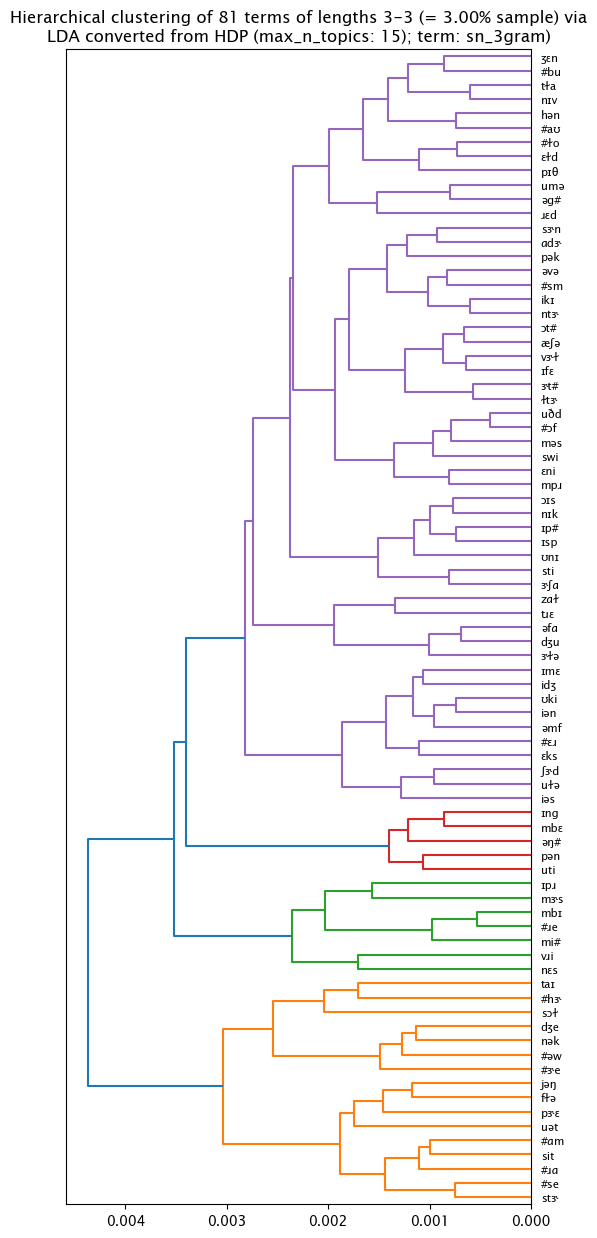

In [161]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
hc_clustering_terms_from_hdp(hdp15, diction, n_topics= 15, lowest_density = 0.001, gap_mark = gap_mark, min_length = 3, sampling_rate = 0.03, use_CJK = False, check = False)

In [162]:
## HDP (n_topics = 45)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 45
hdp45 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data45 = pyLDAvis.gensim.prepare(hdp45, corpus, diction)
pyLDAvis.display(vis_data45)

In [163]:
## save LDAvis output as a html file
lang_dir_name = target_lang_dict[target_lang_key].split()[0]
#save_LDAvis = True
if save_LDAvis:
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data45, vis_output)

In [164]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp45.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    #hdp45_topics_out = f"results/terms-by-topics-raw/hdp{max_n_topics}_topics_raw.csv"
    hdp45_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp45_topics_out, header = False, index = None)
    print(f"saved: {hdp45_topics_out}")

In [165]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp45
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob
#
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: {len(probs.nonzero()[0])}")
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.002 * ɡɫə + 0.002 * isə + 0.002 * məf + 0.002 * doʊ + 0.002 * pɔɪ + 0.002 * ɫəs + 0.002 * tɪd + 0.002 * bɔɫ + 0.002 * #ɡa + 0.002 * ŋkt + 0.002 * vɪd + 0.002 * ɪɹɫ + 0.002 * θæ + 0.002 * əmf + 0.002 * ɫɪp + 0.002 * nu + 0.002 * ntɪ + 0.002 * ɹət + 0.002 * ɹɛz + 0.002 * ɪzɝ
nonzero count: 162
	0.9485: #hwaɪtwɑʃt#
	0.9389: #ənɹivaɪzd#
	0.9302: #ɫəsɪviəs#
	0.9302: #ɹivaɪzd#
	0.9248: #ənnætʃɝəɫ#
	0.9185: #ɪmpɪɹiəs#
	0.9185: #bɫitʃt#
	0.9185: #pɹitin#
	0.9185: #ənmɑɹkt#
	0.9111: #ɫætɝəɫ#
	0.9111: #keɪdʒi#
	0.9111: #nɔɹməɫ#
	0.9111: #əntətʃt#
	0.9111: #ənpeɪntɪd#
	0.9111: #ənwɑʃt#
topic_id 1: 0.003 * ɪf + 0.002 * ʊɫə + 0.002 * nsk + 0.002 * sɑm + 0.002 * fɫɛ + 0.002 * #iv + 0.002 * ɪnə + 0.002 * ɹɔs + 0.002 * ɑdʒ + 0.002 * pɔɹ + 0.002 * nɑp + 0.002 * dɪs + 0.002 * ɫd + 0.002 * ɡeɪ + 0.002 * ʒɪk + 0.002 * ʃɛk + 0.002 * ɛsɪ + 0.002 * iæn + 0.002 * wɛð + 0.002 * bət
nonzero count: 215
	0.9425: #bɪhoʊɫdən#
	0.9348: #ɹəkɔɹdɪd#
	0.9348: #ɪndɪskɹit#
	0.9248: #kɔɹdʒəɫ#
	0.9248: #kɝɛktə

3322 rows remain after density filtering, discarding 0 rows
3315 rows remain after size filtering, discarding 7 rows
99 rows remain after size filtering, discarding 3216 rows


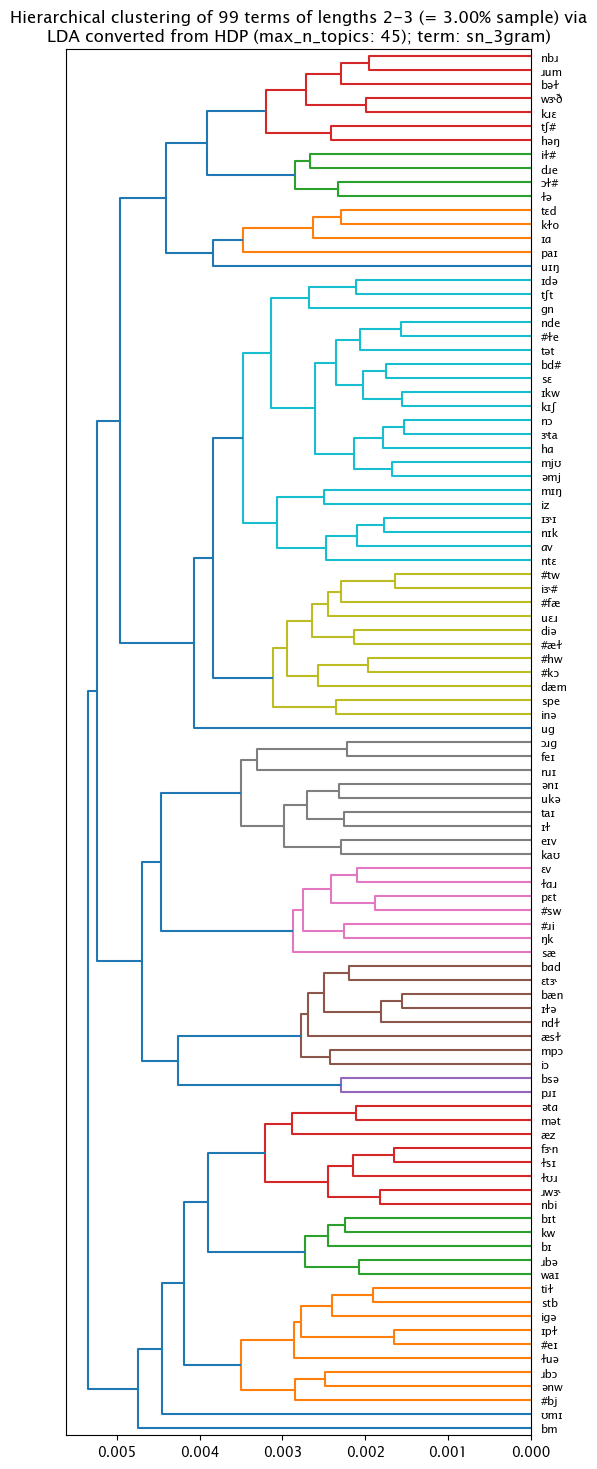

In [166]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
hc_clustering_terms_from_hdp(hdp45, diction, n_topics = 45, lowest_density = 0.004, gap_mark = gap_mark, min_length = 2, sampling_rate = 0.03, check = False)

In [167]:
## HDP (n_topics = 90)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 90
hdp90 = gensim.models.HdpModel(corpus, diction, T = max_n_topics,
                               random_state = 1)
vis_data90 = pyLDAvis.gensim.prepare(hdp90, corpus, diction)
pyLDAvis.display(vis_data90)

In [168]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data90, vis_output)

In [169]:
## save topic structures
if save_topic_structure:
    hdp_topics = hdp90.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }

    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp90_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp90_topics_out, header = False, index = None)
    print(f"saved: {hdp90_topics_out}")

In [170]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp90
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

## investigate topics
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    #topic_encoding = ", ".join(hdp.show_topic(topic_id))
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.003 * ɹɡ + 0.002 * mɛs + 0.002 * ɪɫɑ + 0.002 * ud# + 0.002 * nj + 0.002 * #i + 0.002 * əsɔ + 0.002 * æɹ + 0.002 * kɝ + 0.002 * θɔ + 0.002 * bæɹ + 0.002 * #ɑf + 0.002 * ædv + 0.002 * ɹiɛ + 0.002 * əwɛ + 0.002 * udə + 0.002 * ɪva + 0.002 * kɝə + 0.002 * tsa + 0.002 * pɝm
nonzero count:  81
	0.9342: #ənəpoʊzd#
	0.9295: #wɪnsəm#
	0.9295: #pɔɪnjənt#
	0.9177: #ənəfɹeɪd#
	0.9013: #ɪntɝnəɫ#
	0.9013: #kɝɛkt#
	0.8903: #əfɹeɪd#
	0.8766: #bækt#
	0.8590: #əfʊt#
	0.8355: #bæk#
	0.7532: #ɪn#
	0.7479: #ɑɹktɪk#
	0.7162: #kɹeɪnjəɫ#
	0.7052: #məɫtəpəɫ#
	0.6741: #bæptɪzməɫ#
topic_id 1: 0.002 * #aɪ + 0.002 * ɹd + 0.002 * ti + 0.002 * ɫə + 0.002 * nəf + 0.002 * #va + 0.002 * æʃɪ + 0.002 * tæb + 0.002 * ʊɫ + 0.002 * ut + 0.002 * imɫ + 0.002 * ɡi# + 0.002 * tɝ + 0.002 * əw + 0.002 * ʃt# + 0.002 * ndɹ + 0.002 * ɹis + 0.002 * θɛt + 0.002 * ju + 0.002 * #hə
nonzero count:  153
	0.9342: #hoʊɫsəm#
	0.9295: #tɹuθfəɫ#
	0.9295: #hoʊmɫaɪk#
	0.9241: #ɔdɪtɔɹi#
	0.9241: #hoʊmɫəs#
	0.9178: #hoʊpfəɫ#
	0.9178:

3322 rows remain after density filtering, discarding 0 rows
3315 rows remain after size filtering, discarding 7 rows
99 rows remain after size filtering, discarding 3216 rows


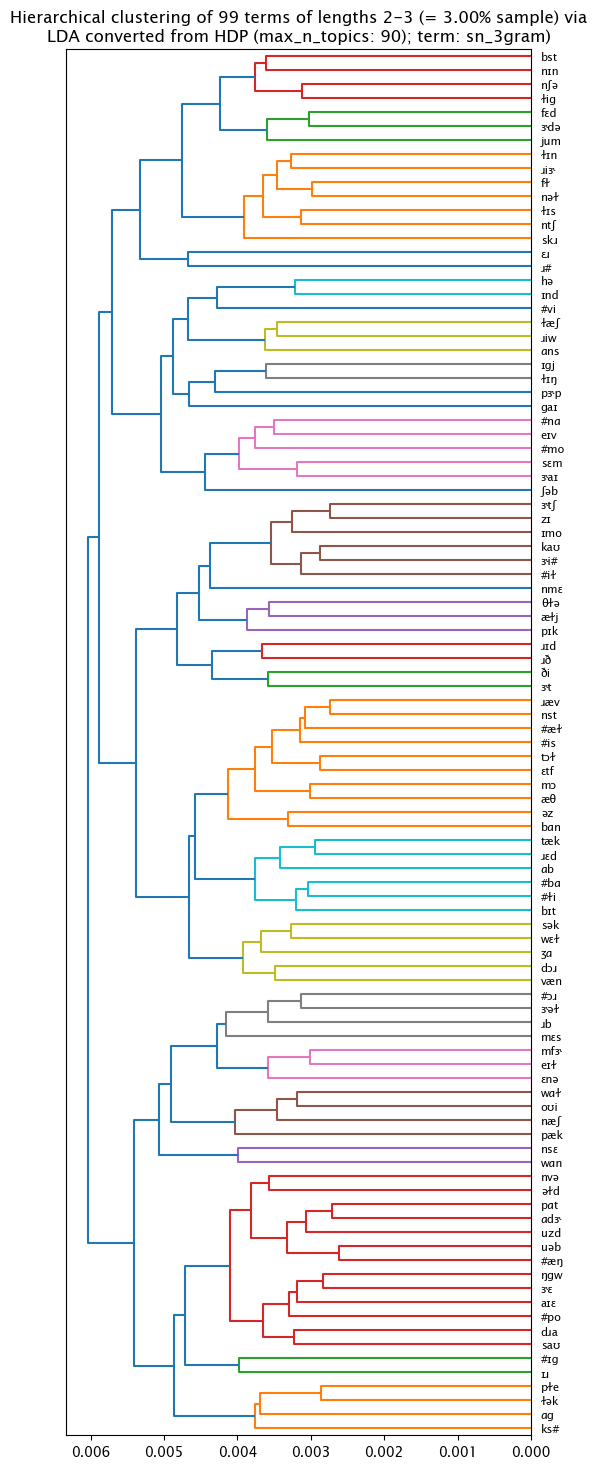

In [171]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
hc_clustering_terms_from_hdp(hdp90, diction, n_topics = 90, gap_mark = gap_mark, lowest_density = 0.005, min_length = 2, sampling_rate = 0.03, check = False)